## Homework I ML in finance


authors: Summer Negahdar, Luna Jian, Jae Jung


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pyarrow.parquet as pq
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [2]:
gw_df= pd.read_csv("gw.csv")
lsret_df= pd.read_csv("lsret.csv", index_col=0)
FRED_df= pd.read_csv("FREDMD.csv")
largeml_df= pd.read_parquet("largeml.pq")
smallml_df= pd.read_parquet("smallml.pq")



### Question one

### Question Two

### Question Three


a. 

b. 

In [47]:
##introducing indicator column for all rows
lsret_df['indicator']= 1 

# Ensure index is datetime
lsret_df.index = pd.to_datetime(lsret_df.index)

train= lsret_df[lsret_df.index< '2004-01-01'].dropna()
test= lsret_df[lsret_df.index >= '2004-01-01'].dropna()
X_train= train.drop(columns= 'indicator')
y_train= train['indicator']
X_test= test.drop(columns= 'indicator')



In [48]:

# scaling features for LASSO and RR
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [49]:
## I am just checking for a few things bc I keep getting LAsso errors
print("Columns with zero variance:", (X_train == 0).all().sum())
print("Duplicated columns:", X_train.T.duplicated().sum())
print("NaNs in X_train_scaled:", np.isnan(X_train_scaled).sum())
print("Infs in X_train_scaled:", np.isinf(X_train_scaled).sum())

Columns with zero variance: 0
Duplicated columns: 0
NaNs in X_train_scaled: 0
Infs in X_train_scaled: 0


In [50]:
#fitting lasso and ridge
lasso = LassoCV(
    cv=5,
    random_state=42,
    max_iter=50000,
    tol=1e-2,
    alphas=np.logspace(-3, -0.5, 30)
).fit(X_train_scaled, y_train)



##I got an error message that in finance means they features are closely correlated. that is why 
# I am increasing number of iterations from 10k to 50k
# relaxing the tolerance
# changing alphas to a smaller range. 



In [51]:
## Now RR
ridge = RidgeCV(cv=5, alphas=[0.1, 1.0, 10.0]).fit(X_train_scaled, y_train)

In [52]:
# Normalize weights
def normalize_weights(coef, model_name):
    total = np.sum(np.abs(coef))
    if total < 1e-10:
        print(f"Warning: {model_name} coefficients sum to near zero; using equal weights")
        return np.ones(len(coef)) / len(coef)
    return coef / total

In [53]:
print("Lasso Coefs:", lasso.coef_)
print("Ridge Coefs:", ridge.coef_)

Lasso Coefs: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Ridge Coefs: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

so the coefficients for LAsso and ridge (which does not cancel out any coef) is zero. this suggests that there is no combination of long-short portfolios that return a flat rate of 1. and since all coefs are zero, our weights will be equally set across all of them. 

In [54]:
w_lasso = normalize_weights(lasso.coef_, "Lasso")
w_ridge = normalize_weights(ridge.coef_, "Ridge")

# Portfolio returns
port_lasso = (X_test @ w_lasso).rename('Lasso Portfolio')  # Use original X_test for returns
port_ridge = (X_test @ w_ridge).rename('Ridge Portfolio')


the formula for sharpe ratio will be

$
\text{Sharpe Ratio} = \frac{\mathbb{E}[R_p] \times 12}{\sigma(R_p) \times \sqrt{12}}
$

In [55]:

# Sharpe ratios
def compute_sharpe(returns, model_name):
    mean = returns.mean() * 12
    std = returns.std() * np.sqrt(12)
    if std < 1e-10:
        print(f"Warning: {model_name} portfolio has near-zero volatility")
        return np.nan
    return mean / std

sharpe_lasso = compute_sharpe(port_lasso, "Lasso")
sharpe_ridge = compute_sharpe(port_ridge, "Ridge")
print(f"Lasso Sharpe Ratio: {sharpe_lasso:.3f}")
print(f"Ridge Sharpe Ratio: {sharpe_ridge:.3f}")

Lasso Sharpe Ratio: 1.844
Ridge Sharpe Ratio: 1.844


as we mentioned before, since the coefs are zero and weights are equal, then the sharpe ratio for both of them will be the same. in this case it will be 1.844 . sharpe ratio measures for risk-adjusted return on the portfolio and in our case the sharpe ratio is considered "good". this implies that the diversification of portfolio will decrease the risk and increase the expected retun on our portfolio even though we failed to "optamize" using Lasso and RR. 


c.

In [56]:
# Determine max factors (e.g., 95% variance or 10)
pca_temp = PCA().fit(X_train_scaled)
cum_variance = np.cumsum(pca_temp.explained_variance_ratio_)
max_factors = min(np.searchsorted(cum_variance, 0.95) + 1, X_train.shape[1], 10)
factor_counts = list(range(1, max_factors + 1))

# Initialize lists for Sharpe ratios
sharpe_lasso_list = []
sharpe_ridge_list = []

In [57]:
# PCA and lasso/ridge for each factor count
for n in factor_counts:
    try:
        # PCA
        pca = PCA(n_components=n)
        X_train_pca = pca.fit_transform(X_train_scaled)
        X_test_pca = pca.transform(X_test_scaled)
        
        # Scale PCA factors
        scaler_factors = StandardScaler()
        X_train_pca_scaled = scaler_factors.fit_transform(X_train_pca)
        X_test_pca_scaled = scaler_factors.transform(X_test_pca)
        
        # Lasso and ridge
        lasso = LassoCV(cv=5, random_state=42, max_iter=50000, tol=1e-3, alphas=np.logspace(-8, -2, 50)).fit(X_train_pca_scaled, y_train)
        ridge = RidgeCV(cv=5, alphas=[0.001, 0.01, 0.1, 1.0]).fit(X_train_pca_scaled, y_train)
        
        # Normalize weights
        def normalize_weights(coef, model_name, n_factors):
            total = np.sum(np.abs(coef))
            if total < 1e-10:
                print(f"Warning: {model_name} coefficients sum to near zero for {n_factors} factors; using equal weights")
                return np.ones(len(coef)) / len(coef)
            return coef / total
        
        w_lasso = normalize_weights(lasso.coef_, "Lasso", n)
        w_ridge = normalize_weights(ridge.coef_, "Ridge", n)
        
        # Portfolio returns
        port_lasso = pd.Series(X_test_pca_scaled @ w_lasso).rename(f'Lasso_{n}')
        port_ridge = pd.Series(X_test_pca_scaled @ w_ridge).rename(f'Ridge_{n}')
        
        # Sharpe ratios
        def compute_sharpe(returns, model_name, n_factors):
            mean = returns.mean() * 12
            std = returns.std() * np.sqrt(12)
            if std < 1e-10 or np.isnan(std):
                print(f"Warning: {model_name} portfolio has near-zero or NaN volatility for {n_factors} factors")
                return np.nan
            return mean / std
        
        sharpe_lasso = compute_sharpe(port_lasso, "Lasso", n)
        sharpe_ridge = compute_sharpe(port_ridge, "Ridge", n)
        
        sharpe_lasso_list.append(sharpe_lasso if not np.isnan(sharpe_lasso) else np.nan)
        sharpe_ridge_list.append(sharpe_ridge if not np.isnan(sharpe_ridge) else np.nan)
        
    except Exception as e:
        print(f"Error for {n} factors: {e}")
        sharpe_lasso_list.append(np.nan)
        sharpe_ridge_list.append(np.nan)

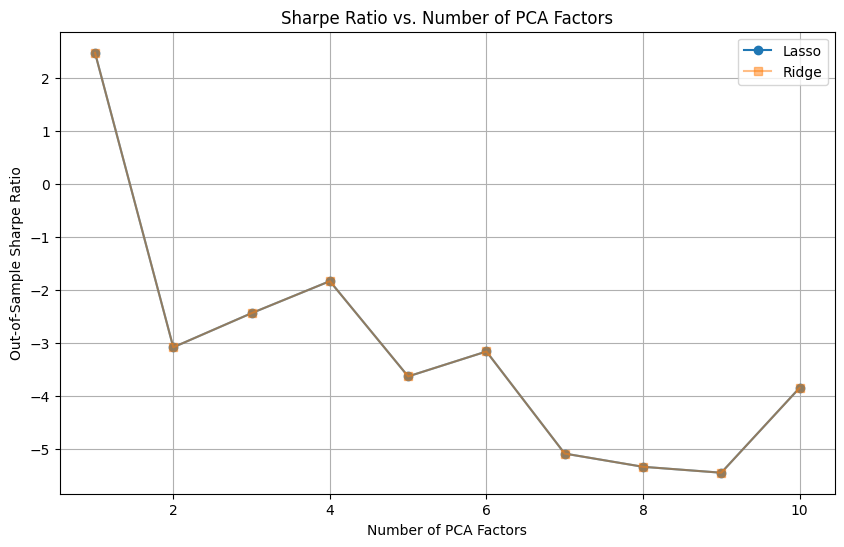

In [61]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(factor_counts, sharpe_lasso_list, marker='o', label='Lasso')
plt.plot(factor_counts, sharpe_ridge_list, marker='s',alpha= 0.5, label='Ridge')
plt.xlabel('Number of PCA Factors')
plt.ylabel('Out-of-Sample Sharpe Ratio')
plt.title('Sharpe Ratio vs. Number of PCA Factors')
plt.legend()
plt.grid(True)
plt.show()

they fall perfectly on each other, and also looking at thr R^2, we see that post 4th PC, we don't see much addition to the interpretation power. 
based on Fama-French factors, we want sharpe ratio to increase initially, showcasing the capturing of institutional differences in small numbers or PCA. 

R^2 (Proportion of Variance Explained) for Each PC:
PC1: R^2 = 0.3727, Cumulative R^2 = 0.3727
PC2: R^2 = 0.1377, Cumulative R^2 = 0.5104
PC3: R^2 = 0.0836, Cumulative R^2 = 0.5940
PC4: R^2 = 0.0696, Cumulative R^2 = 0.6635
PC5: R^2 = 0.0401, Cumulative R^2 = 0.7036
PC6: R^2 = 0.0331, Cumulative R^2 = 0.7367
PC7: R^2 = 0.0242, Cumulative R^2 = 0.7608
PC8: R^2 = 0.0219, Cumulative R^2 = 0.7828
PC9: R^2 = 0.0182, Cumulative R^2 = 0.8009
PC10: R^2 = 0.0165, Cumulative R^2 = 0.8174


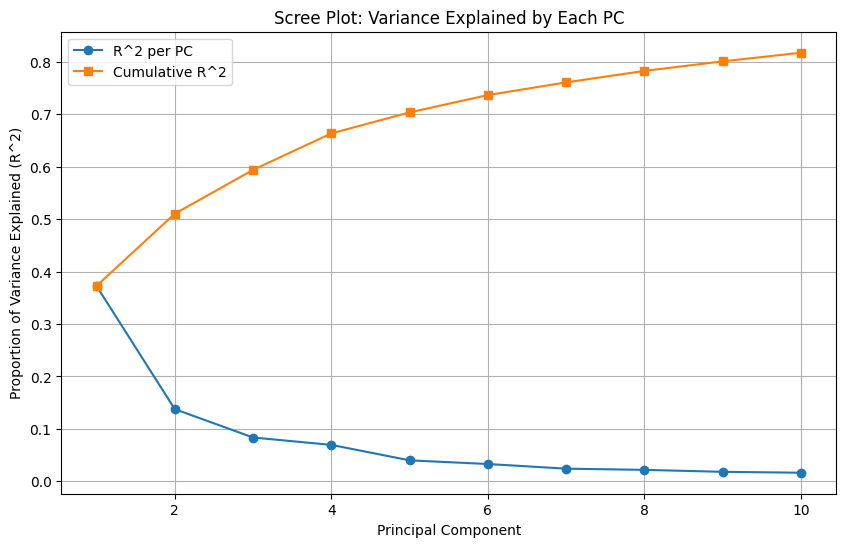

In [ ]:
# Fit PCA to get R^2 for each PC
pca_full = PCA()
pca_full.fit(X_train_scaled)
r2_per_pc = pca_full.explained_variance_ratio_
cum_r2 = np.cumsum(r2_per_pc)
# Display R^2 for each PC (up to 10 or total PCs)
num_pcs_to_show = min(len(r2_per_pc), 10)
print("R^2 (Proportion of Variance Explained) for Each PC:")
for i in range(num_pcs_to_show):
    print(f"PC{i+1}: R^2 = {r2_per_pc[i]:.4f}, Cumulative R^2 = {cum_r2[i]:.4f}")

# Scree plot: I want to see how much R^2 each PC adds to the model
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_pcs_to_show + 1), r2_per_pc[:num_pcs_to_show], marker='o', label='R^2 per PC')
plt.plot(range(1, num_pcs_to_show + 1), cum_r2[:num_pcs_to_show], marker='s', label='Cumulative R^2')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained (R^2)')
plt.title('Scree Plot: Variance Explained by Each PC')
plt.legend()
plt.grid(True)
plt.show()


Loadings for the First 3 Principal Components:

PC1 (R^2 = 0.3727):
              Portfolio   Loading
16                 Beta  0.110805
21         BookLeverage  0.110092
171          ShareIss1Y -0.109998
128    NetEquityFinance -0.109952
195           fgr5yrLag -0.109237
129      NetPayoutYield -0.108836
149     PriceDelayTstat -0.108713
172          ShareIss5Y -0.108449
77   ForecastDispersion -0.108439
188                XFIN -0.108221


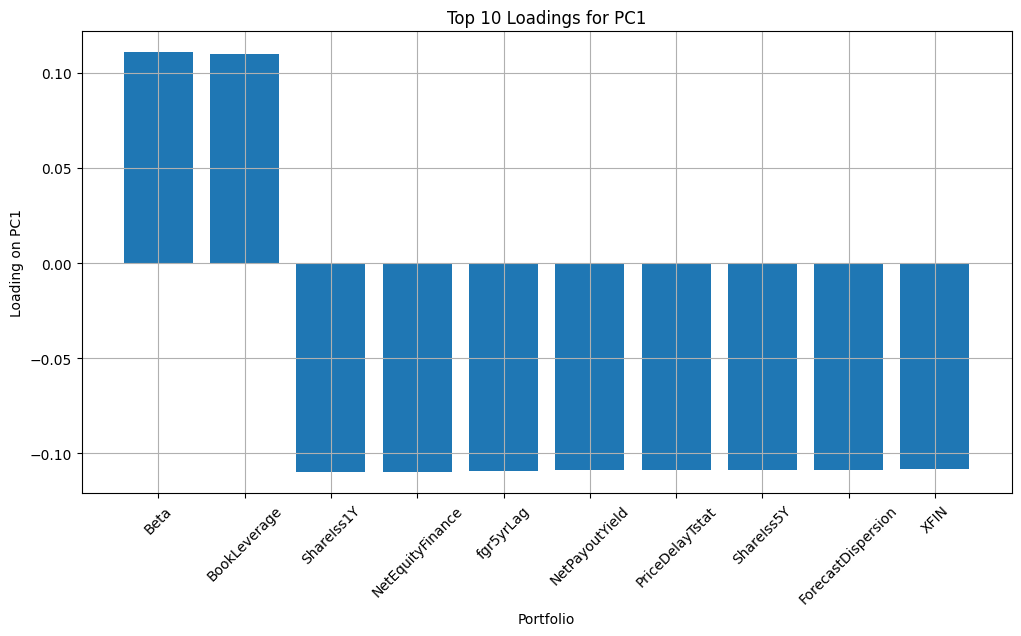


PC2 (R^2 = 0.1377):
        Portfolio   Loading
60         DolVol  0.161288
154           RDS  0.158813
52         DelEqu  0.155789
29           ChEQ  0.152027
176          Size  0.150263
114  MomOffSeason  0.148816
12    AssetGrowth  0.148349
100       IntanSP  0.148241
104    LRreversal  0.147161
198          hire  0.143192


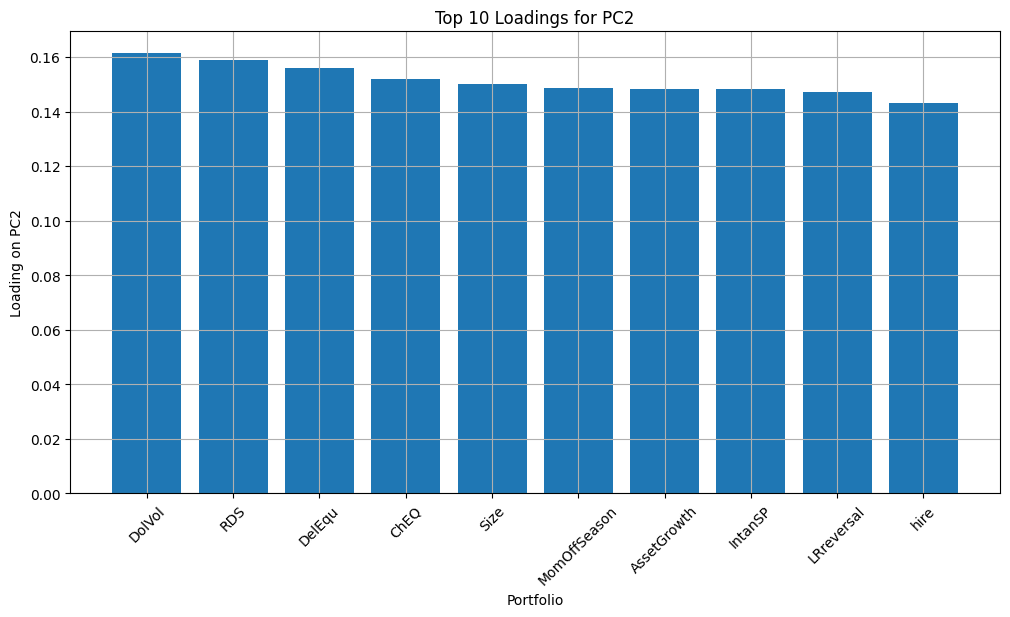


PC3 (R^2 = 0.0836):
                  Portfolio   Loading
197                grcapx3y  0.158482
51                   DelDRC -0.155788
182             TrendFactor -0.154984
175           ShortInterest  0.149262
206                   skew1  0.147334
82                  GrLTNOA -0.145510
138         OrderBacklogChg  0.144227
196                  grcapx  0.142833
22              BrandInvest  0.135266
37   ChangeInRecommendation -0.131469


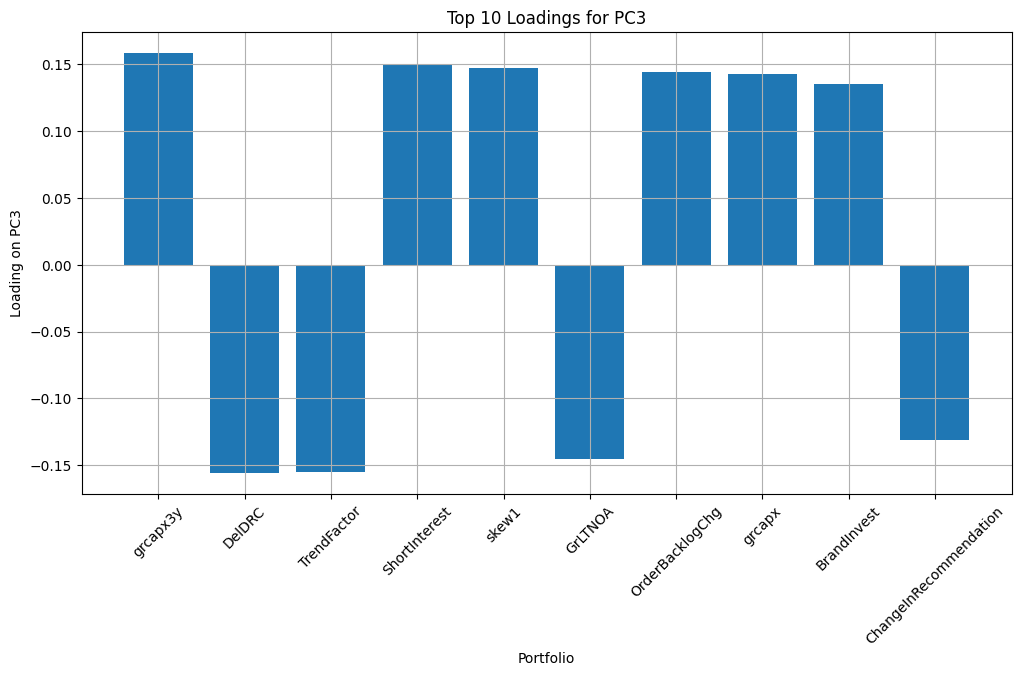

In [ ]:
##I want to see the details of the loadings. 
# Extract and interpret loadings for the first 3 PCs
num_pcs_to_interpret = min(3, pca_full.n_components_)
print("\nLoadings for the First 3 Principal Components:")
for i in range(num_pcs_to_interpret):
    loadings = pca_full.components_[i]
    # Map loadings to portfolio names
    loading_df = pd.DataFrame({
        'Portfolio': X_train.columns,
        'Loading': loadings
    })

# Sort by absolute loading for clarity
    loading_df = loading_df.reindex(loading_df['Loading'].abs().sort_values(ascending=False).index)
    print(f"\nPC{i+1} (R^2 = {r2_per_pc[i]:.4f}):")
    print(loading_df.head(10))  # Top 10 portfolios by absolute loading
    # Optional: Plot loadings
    plt.figure(figsize=(12, 6))
    plt.bar(loading_df['Portfolio'][:10], loading_df['Loading'][:10])
    plt.xlabel('Portfolio')
    plt.ylabel(f'Loading on PC{i+1}')
    plt.title(f'Top 10 Loadings for PC{i+1}')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

a few notes:
the negative Vs. postivie signs suggrsts that those certain portfolio loadings move in the opposite direction of each other.
but in terms of magnitude, most loadings in each pf these PCs have around the same size, suggesting that these effect that certain PC almost equally!


d.

In [74]:
# Problem 3(b) for largeml.pq (Large-Cap Portfolio)
results_3b_largeml = {}  # Store 3(b) results for largeml

print("\nProcessing largeml for Problem 3(b):")

# Ensure datetime index
largeml_df.index = pd.to_datetime(largeml_df.index)

# Prepare data with constant indicator
largeml_df['indicator'] = 1

# Use the same split date as lsret.csv
split_date = pd.to_datetime('2004-01-01')
print(f"Using split date {split_date} for largeml")

trainL = largeml_df[largeml_df.index < split_date].dropna()
testL = largeml_df[largeml_df.index >= split_date].dropna()
X_trainL = trainL.drop(columns='indicator')
y_trainL = trainL['indicator']
X_testL = testL.drop(columns='indicator')

# Scale features
scaler = StandardScaler()
X_train_scaledL = scaler.fit_transform(X_trainL)
X_test_scaledL = scaler.transform(X_testL)

# Lasso and ridge
lasso = LassoCV(cv=5, random_state=42, max_iter=50000, tol=1e-3, alphas=np.logspace(-10, -4, 50)).fit(X_train_scaledL, y_trainL)
ridge = RidgeCV(cv=5, alphas=[0.001, 0.01, 0.1, 1.0]).fit(X_train_scaledL, y_trainL)

# Normalize weights
def normalize_weights(coef, model_name):
    total = np.sum(np.abs(coef))
    if total < 1e-10:
        print(f"Warning: {model_name} coefficients sum to near zero in largeml; using equal weights")
        return np.ones(len(coef)) / len(coef)
    return coef / total

w_lassoL = normalize_weights(lasso.coef_, "Lasso")
w_ridgeL = normalize_weights(ridge.coef_, "Ridge")

# Portfolio returns
port_lassoL = pd.Series(X_test_scaledL @ w_lassoL, index=X_testL.index).rename('largeml_Lasso')
port_ridgeL = pd.Series(X_test_scaledL @ w_ridgeL, index=X_testL.index).rename('largeml_Ridge')

# Sharpe ratios
def compute_sharpe(returns, model_name):
    mean = returns.mean() * 12
    std = returns.std() * np.sqrt(12)
    if std < 1e-10 or np.isnan(std):
        print(f"Warning: {model_name} portfolio has near-zero or NaN volatility in largeml")
        return np.nan
    return mean / std

sharpe_lassoL = compute_sharpe(port_lassoL, "Lasso")
sharpe_ridgeL = compute_sharpe(port_ridgeL, "Ridge")

print(f"largeml Lasso Sharpe: {sharpe_lassoL:.3f}")
print(f"largeml Ridge Sharpe: {sharpe_ridgeL:.3f}")
results_3b_largeml['largeml'] = {'lasso_sharpe': sharpe_lasso, 'ridge_sharpe': sharpe_ridge}


Processing largeml for Problem 3(b):
Using split date 2004-01-01 00:00:00 for largeml


ValueError: Found array with 0 sample(s) (shape=(0, 212)) while a minimum of 1 is required by StandardScaler.


Processing largeml for Problem 3(c):
Using split date 2010-01-01 00:00:00 for largeml
Error: No training data available before 2010-01-01 00:00:00 for largeml
